# 1. Installs

In [1]:
!pip install transformers datasets
!pip install seaborn
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.9.0.13 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cudnn-cu12==9.1.0.70; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cudnn-cu12 9.3.0.75 which is incompatible.
torch 2.6.0+cu124 requires nvid

# 2. Imports

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
import os

import pandas as pd
import numpy as np

import shutil

import re

import matplotlib.pyplot as plt

import seaborn as sns

from datasets import load_dataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

import torch

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# 3. Definitions

In [5]:
MODEL_NAME = "roberta-base"  # Английская модель
XLM_MODEL_NAME = "xlm-roberta-base"  # Многоязычная модель
MAX_LENGTH = 256
NUM_CLASSES = 3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42

DATA_DIR = "/kaggle/input/contradictory-my-dear-watson/"
RESULT_DICT = {
        0 : "entailment",
        1 : "neutral",
        2 : "contradiction"}

In [6]:
# Disable Weights & Biases tracking and tokenizer parallelism for this session.
os.environ["WANDB_DISABLED"] = "true"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# 4. Analize the dataset

In [7]:
for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [8]:
train_df = pd.read_csv(DATA_DIR + "/train.csv")
train_df.head()

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1


In [9]:
test_df = pd.read_csv(DATA_DIR + "/test.csv")
test_df.head()

,id,premise,hypothesis,lang_abv,language
0,c6d58c3f69,بکس، کیسی، راہیل، یسعیاہ، کیلی، کیلی، اور کولم...,"کیسی کے لئے کوئی یادگار نہیں ہوگا, کولمین ہائی...",ur,Urdu
1,cefcc82292,هذا هو ما تم نصحنا به.,عندما يتم إخبارهم بما يجب عليهم فعله ، فشلت ال...,ar,Arabic
2,e98005252c,et cela est en grande partie dû au fait que le...,Les mères se droguent.,fr,French
3,58518c10ba,与城市及其他公民及社区组织代表就IMA的艺术发展进行对话&amp,IMA与其他组织合作，因为它们都依靠共享资金。,zh,Chinese
4,c32b0d16df,Она все еще была там.,"Мы думали, что она ушла, однако, она осталась.",ru,Russian


In [10]:
def display_pair_of_sentence(x):
    print( "Premise : " + x['premise'])
    print( "Hypothesis: " + x['hypothesis'])
    print( "Language: " + x['language'])
    print( "Label: " + str(x['label']))
    print()

train_df.head(10).apply(lambda x : display_pair_of_sentence(x), axis=1)

Premise : and these comments were considered in formulating the interim rules.
Hypothesis: The rules developed in the interim were put together with these comments in mind.
Language: English
Label: 0

Premise : These are issues that we wrestle with in practice groups of law firms, she said. 
Hypothesis: Practice groups are not permitted to work on these issues.
Language: English
Label: 2

Premise : Des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.
Hypothesis: J'essayais d'accomplir quelque chose.
Language: French
Label: 0

Premise : you know they can't really defend themselves like somebody grown uh say my age you know yeah
Hypothesis: They can't defend themselves because of their age.
Language: English
Label: 0

Premise : ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้
Hypothesis: เด็กสามารถเห็นได้ว่าชาติพันธุ

0    None
1    None
2    None
3    None
4    None
5    None
6    None
7    None
8    None
9    None
dtype: object

Text(0.5, 1.0, 'Distribution of labels in the training set')

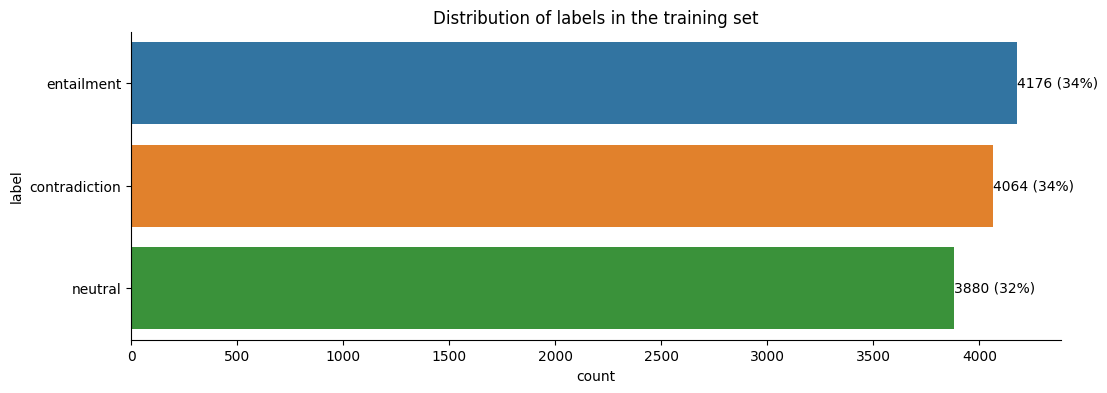

In [11]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(12, 4))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=train_df,
                   y="label",
                   order = train_df['label'].value_counts().index)

abs_values = train_df['label'].value_counts(ascending=False)
rel_values = train_df['label'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])

ax.set_title("Distribution of labels in the training set")

In [12]:
# set number of classes of the label.
NUM_CLASSES = 3

Text(0.5, 1.0, 'Distribution of languages in the training set')

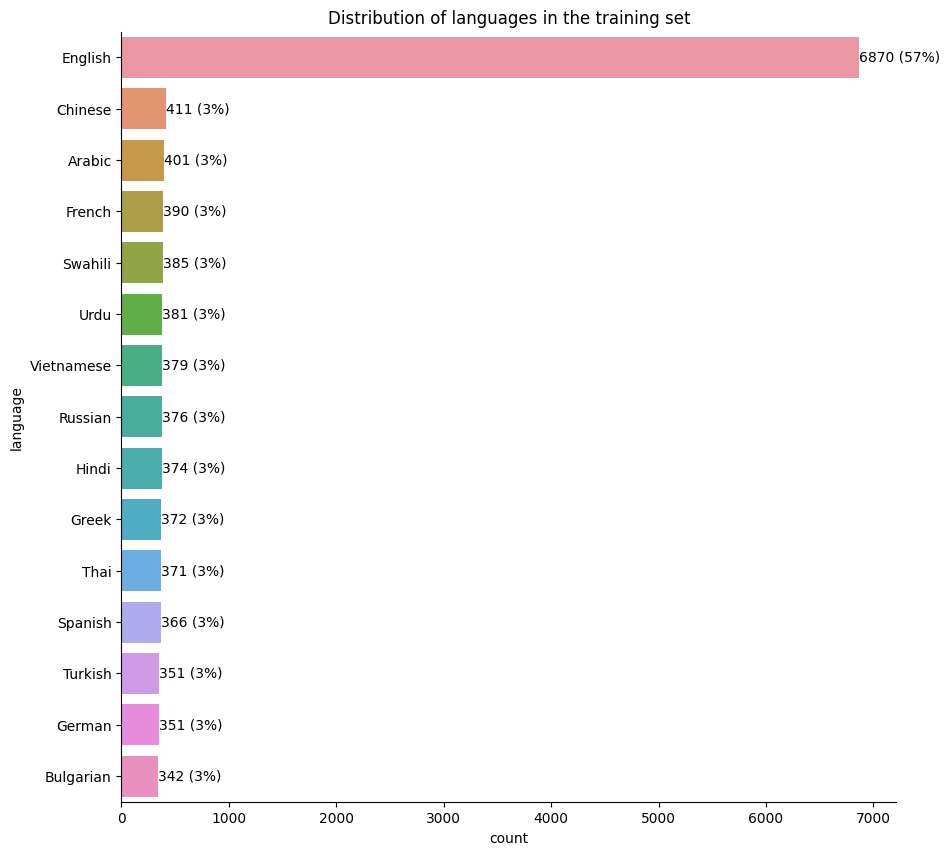

In [13]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 10))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=train_df,
                   y="language",
                   order = train_df['language'].value_counts().index)

abs_values = train_df['language'].value_counts(ascending=False)
rel_values = train_df['language'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_title("Distribution of languages in the training set")

In [14]:
# Distribution of languages in the dataset
language_counts = train_df['language'].value_counts()
print("Language distribution:")
print(language_counts)

Language distribution:
language
English       6870
Chinese        411
Arabic         401
French         390
Swahili        385
Urdu           381
Vietnamese     379
Russian        376
Hindi          374
Greek          372
Thai           371
Spanish        366
Turkish        351
German         351
Bulgarian      342
Name: count, dtype: int64


In [15]:
# Split the dataset into English and non-English subsets
english_df = train_df[train_df['language'] == 'English']
non_english_df = train_df[train_df['language'] != 'English']

In [16]:
# Split the dataset into English and non-English subsets
english_test_df = test_df[test_df['language'] == 'English']
non_english_test_df = test_df[test_df['language'] != 'English']

In [17]:
print(f"\nEnglish subset: {len(english_df)} samples")
print(f"Non-English subset: {len(non_english_df)} samples")


English subset: 6870 samples
Non-English subset: 5250 samples


In [18]:
# text samples
train_df[['premise', 'hypothesis']].sample(5)

# check missing values
print("Missing values:\n", train_df[['premise', 'hypothesis']].isnull().sum())

# check wird chars

train_df['special_chars'] = train_df['premise'].apply(lambda x: re.findall(r'[^\w\s]', x))
print("Samples of text with special chars:\n", train_df[['premise', 'special_chars']].head())

Missing values:
 premise       0
hypothesis    0
dtype: int64
Samples of text with special chars:
                                              premise  \
0  and these comments were considered in formulat...   
1  These are issues that we wrestle with in pract...   
2  Des petites choses comme celles-là font une di...   
3  you know they can't really defend themselves l...   
4  ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...   

                                       special_chars  
0                                                [.]  
1                                             [,, .]  
2                                          [-, ', .]  
3                                                [']  
4  [่, ุ, ิ, ็, ่, ั, ี, ่, ้, ้, ่, ้, ั, ่, ้, ...  


Text(0.5, 1.0, 'Distribution of labels in the training set')

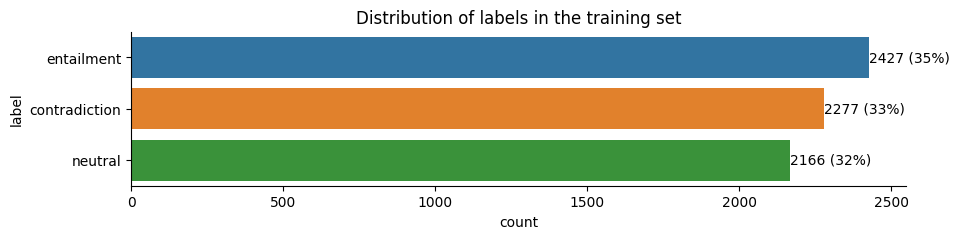

In [19]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(10, 2))

# Plot the total crashes
sns.set_color_codes("pastel")
sns.despine()
ax = sns.countplot(data=english_df,
                   y="label",
                   order = english_df['label'].value_counts().index)

abs_values = english_df['label'].value_counts(ascending=False)
rel_values = english_df['label'].value_counts(ascending=False, normalize=True).values * 100
lbls = [f'{p[0]} ({p[1]:.0f}%)' for p in zip(abs_values, rel_values)]

ax.bar_label(container=ax.containers[0], labels=lbls)

ax.set_yticklabels([RESULT_DICT[index] for index in abs_values.index])

ax.set_title("Distribution of labels in the training set")

# 5. Training preparing

In [20]:
import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification


SEED = 42
MAX_LENGTH = 256
MODEL_NAME = "joeddav/xlm-roberta-large-xnli"


tokenizer = XLMRobertaTokenizer.from_pretrained(MODEL_NAME)
model = XLMRobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=3)
model.eval()



2025-06-01 12:52:32.748780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748782352.953103      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748782353.010939      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/734 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


XLMRobertaForSequenceClassification(
  (roberta): XLMRobertaModel(
    (embeddings): XLMRobertaEmbeddings(
      (word_embeddings): Embedding(250002, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): XLMRobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x XLMRobertaLayer(
          (attention): XLMRobertaAttention(
            (self): XLMRobertaSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): XLMRobertaSelfOutput(
              (dense): Linear(in_features=1024, ou

Accuracy: 0.3000

Classification Report:
               precision    recall  f1-score   support

   entailment     0.0357    0.0256    0.0299        39
      neutral     0.7879    0.9286    0.8525        28
contradiction     0.0769    0.0909    0.0833        33

     accuracy                         0.3000       100
    macro avg     0.3002    0.3484    0.3219       100
 weighted avg     0.2599    0.3000    0.2778       100



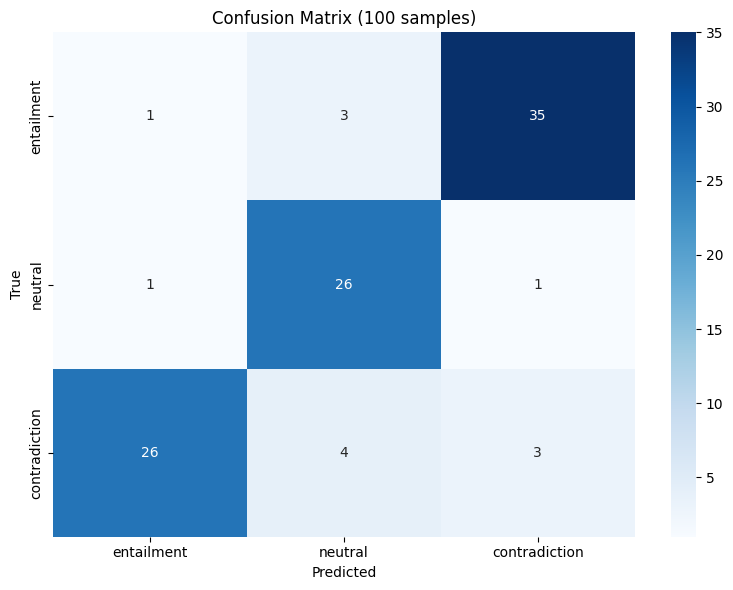


Additional Statistics:
Total samples: 100
Entailment samples: 39
Neutral samples: 28
Contradiction samples: 33

Number of errors: 70

Sample error cases:

Premise: He married Dona Filipa Moniz (Perestrelo), the daughter of Porto Santo's first governor, and lived on the island for a period, fathering a son there.
Hypothesis: He landed on the island but soon left for greener pastures, before later dying alone and childless.
True: contradiction, Predicted: entailment

Premise: They returned to live in the Galilee village of Nazareth, making pilgrimages to Jerusalem.
Hypothesis: They would make pilgrimages to Jerusalem.
True: entailment, Predicted: contradiction

Premise: An Indian traveler described the prosperous Bujang Valley settlement as  the seat of all felicities.  
Hypothesis: A traveler said the settlement was prospering. 
True: entailment, Predicted: contradiction


In [21]:
# Функция для предсказания
def predict_nli(premise, hypothesis):
    inputs = tokenizer(premise, hypothesis, return_tensors='pt',
                      truncation=True, padding=True, max_length=MAX_LENGTH)
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.argmax(outputs.logits, dim=1).item()

# Загрузка данных
eval_df = english_df.sample(n=100, random_state=SEED)


premises = eval_df['premise'].tolist()
hypotheses = eval_df['hypothesis'].tolist()
true_labels = eval_df['label'].tolist()

# Получение предсказаний
predicted_labels = [predict_nli(prem, hyp) for prem, hyp in zip(premises, hypotheses)]

# Вычисление метрик
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}\n")

# Отчет о классификации
print("Classification Report:")
print(classification_report(true_labels, predicted_labels,
                          target_names=["entailment", "neutral", "contradiction"],
                          digits=4))

# Матрица ошибок
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=["entailment", "neutral", "contradiction"],
           yticklabels=["entailment", "neutral", "contradiction"])
plt.title('Confusion Matrix (100 samples)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# Дополнительная статистика
print("\nAdditional Statistics:")
print(f"Total samples: {len(true_labels)}")
print(f"Entailment samples: {sum(1 for x in true_labels if x == 0)}")
print(f"Neutral samples: {sum(1 for x in true_labels if x == 1)}")
print(f"Contradiction samples: {sum(1 for x in true_labels if x == 2)}")

# Примеры ошибочных предсказаний
errors = []
for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)):
    if true != pred:
        errors.append({
            'premise': premises[i],
            'hypothesis': hypotheses[i],
            'true_label': ["entailment", "neutral", "contradiction"][true],
            'predicted_label': ["entailment", "neutral", "contradiction"][pred]
        })

print(f"\nNumber of errors: {len(errors)}")
if errors:
    print("\nSample error cases:")
    for error in errors[:3]:  # Показываем первые 3 ошибки
        print(f"\nPremise: {error['premise']}")
        print(f"Hypothesis: {error['hypothesis']}")
        print(f"True: {error['true_label']}, Predicted: {error['predicted_label']}")

## Debug configuration (if needed DEBUG=True)

In [22]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split

DEBUG = False

df_train = pd.read_csv(DATA_DIR + "/train.csv")
df_test = pd.read_csv(DATA_DIR + "/test.csv") # в тестовом наборе нет меток, пэтому для валидации не подходит
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42, shuffle=False) # на валидацию 10% трэйна

df_debug_train, _ = train_test_split(df_train, test_size=0.99, random_state=42, shuffle=True)
df_debug_val, _ = train_test_split(df_val, test_size=0.99, random_state=42, shuffle=False)
df_debug_test, _ = train_test_split(df_test, test_size=0.99, random_state=42, shuffle=False)

if DEBUG:
    df_train = df_debug_train
    df_val = df_debug_val
    df_test = df_debug_test

dataset = {
    "train": Dataset.from_pandas(df_train),
    "val": Dataset.from_pandas(df_val),
    "test": Dataset.from_pandas(df_test)
}

len(df_test)

5195

In [23]:
print("Columns in original dataset:", dataset["train"].column_names)
print("Columns in validation:", dataset["val"].column_names)

def tokenize_function(examples):
    tokenized = tokenizer(
        examples["premise"],
        examples["hypothesis"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )
    tokenized["labels"] = examples["label"]
    return tokenized

def tokenize_test_function(examples): # отдельный токенизатор для теста, тк нет label
    return tokenizer(
        examples["premise"],
        examples["hypothesis"],
        padding="max_length",
        truncation=True,
        max_length=128,
    )

tokenized_datasets = {
    "train": dataset["train"].map(tokenize_function, batched=True), # 30 примеров > 128 символов
    "val": dataset["val"].map(tokenize_function, batched=True), # 3 примера > 128 символов
    "test": dataset["test"].map(tokenize_test_function, batched=True) # 10 примеров > 128 символов
}

Columns in original dataset: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', '__index_level_0__']
Columns in validation: ['id', 'premise', 'hypothesis', 'lang_abv', 'language', 'label', '__index_level_0__']


Map:   0%|          | 0/10908 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

Map:   0%|          | 0/1212 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


Map:   0%|          | 0/5195 [00:00<?, ? examples/s]

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pai

In [24]:
from transformers import TrainingArguments, Trainer
import numpy as np

from evaluate import load  # Новый способ загрузки метрик

def compute_metrics(eval_pred):
    accuracy_metric = load("accuracy")
    f1_metric = load("f1")

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    metrics = {
      "accuracy" : accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
      "f1" : f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }
    return {f"eval_{k}": v for k, v in metrics.items()}


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    eval_steps=500,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    fp16=True,
    save_strategy="epoch",  # Сохранять после каждой эпохи
    save_total_limit=1,     # Хранить только последний чекпойнт (перезаписывать)
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    logging_steps=50,
    overwrite_output_dir=True,  # Разрешить перезапись папки
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [25]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    compute_metrics=compute_metrics
)

In [26]:
torch.cuda.empty_cache()

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.451500,0.372658,0.877063,0.876832
2,0.826100,1.535479,0.870462,0.870373
3,0.813700,2.026623,0.863861,0.865129
4,0.718900,1.665438,0.879538,0.879403
5,0.536900,2.025588,0.872112,0.872141
6,0.415600,1.982986,0.881188,0.881415
7,0.252900,1.836919,0.886139,0.885504
8,0.083500,1.871410,0.886964,0.887199
9,0.008500,1.899409,0.885314,0.885807
10,0.080800,1.851037,0.888614,0.888751


TrainOutput(global_step=13640, training_loss=0.42837414901459153, metrics={'train_runtime': 13408.4754, 'train_samples_per_second': 8.135, 'train_steps_per_second': 1.017, 'total_flos': 2.541385414573056e+16, 'train_loss': 0.42837414901459153, 'epoch': 10.0})

In [27]:
if not DEBUG:
    model.save_pretrained("./xlm-roberta-finetuned")
    tokenizer.save_pretrained("./xlm-roberta-finetuned")

In [28]:
metrics = trainer.evaluate()
metrics

{'eval_accuracy': 0.8886138613861386,
 'eval_f1': 0.8887514560959872,
 'eval_loss': 1.8510369062423706,
 'eval_runtime': 32.8821,
 'eval_samples_per_second': 36.859,
 'eval_steps_per_second': 2.311,
 'epoch': 10.0}

In [29]:
# predictions_val = trainer.predict(tokenized_datasets["val"])

# # predictions содержит несколько полей, включая logits
# logits_val = predictions_val.predictions
# predicted_labels_val = np.argmax(logits_val, axis=-1)  # преобразуем logits в метки классов
# predicted_labels_val

In [30]:
# submission = df_val.id.copy().to_frame()
# submission["prediction"] = predicted_labels_val

# submission

# Submission file

In [31]:
predictions = trainer.predict(tokenized_datasets["test"])

logits = predictions.predictions
predicted_labels = np.argmax(logits, axis=-1)  # преобразуем logits в метки классов
predicted_labels

array([2, 1, 0, ..., 0, 0, 2])

In [32]:
submission = df_test.id.copy().to_frame()
submission["prediction"] = predicted_labels

submission

,id,prediction
0,c6d58c3f69,2
1,cefcc82292,1
2,e98005252c,0
3,58518c10ba,1
4,c32b0d16df,1
...,...,...
5190,5f90dd59b0,1
5191,f357a04e86,1
5192,1f0ea92118,0
5193,0407b48afb,0


In [33]:
submission.to_csv("submission.csv", index=False)

In [34]:
# # clear output
# !rm -rf /kaggle/working/logs
# !rm -rf /kaggle/working/results